# 0.03 Generate Anomalies S2S

---

Uses the climatology generated in `0.02_generate_climatology_S2S` to create anomalies from the S2S forecasting system.

In [1]:
%load_ext lab_black

import xarray as xr
import glob

from dask.distributed import Client

In [2]:
client = Client("tcp://10.12.205.11:42722")

In [3]:
clim = xr.open_zarr(
    "/glade/scratch/rbrady/abby_S2S/CESM1.S2S.tas_2m.climatology.zarr/",
    consolidated=True,
)
raw = xr.open_zarr(
    "/glade/scratch/rbrady/abby_S2S/CESM1.S2S.tas_2m.raw.zarr/", consolidated=True
)

Going to just create ensemble mean anomalies for now. Having a little trouble with chunking strategies to get anomalies generated for each ensemble member. **NOTE**: If you want to have individual ensemble member anomalies for e.g. probabilistic metrics, just do it for each member separately (e.g. `raw.isel(member=0)` and so on) then save them out separately and concatenate them later.

In [4]:
ensmean = raw.mean("member")

In [5]:
# Matching the chunking strategy for `clim` to make the computation more efficient.
ensmean = ensmean.chunk({"lead": 1, "lat": -1, "lon": 180, "init": "auto"}).persist()

In [6]:
anom = ensmean.groupby("init.dayofyear") - clim

Generally have to rechunk after an operation like this to make sure chunk sizes are uniform. Also doing a groupby command like that returns a result with really small chunks. Keep in mind with `zarr` the power is that they get loaded in chunk-aware. So I make the inits one large chunk, knowing we'll operate on the full init dimension with `climpred` for operations.

In [7]:
anom = anom.chunk({"lat": "auto", "lon": "auto", "init": -1, "lead": 1}).persist()

In [8]:
%time anom.to_zarr("/glade/scratch/rbrady/S2S/CESM1.S2S.tas_2m.anom.zarr/", consolidated=True)

CPU times: user 147 ms, sys: 91.6 ms, total: 239 ms
Wall time: 43.2 s


Looks like they are in anomaly format!

In [9]:
test = xr.open_zarr(
    "/glade/scratch/rbrady/S2S/CESM1.S2S.tas_2m.anom.zarr/", consolidated=True
)

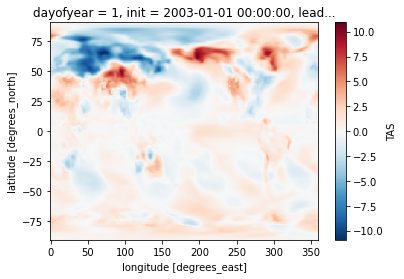

In [10]:
test.TAS.isel(init=10, lead=10).plot()